In [12]:
# Core libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
# ML preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder


In [4]:
df = pd.read_csv("C:/customer-churn/data/raw_churn.csv")
df = df.drop('customerID', axis=1)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)



C:\Users\mrudu\AppData\Local\Temp\ipykernel_15620\543749220.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


In [5]:
le = LabelEncoder()
df['Churn'] = le.fit_transform(df['Churn'])

In [6]:
X = df.drop('Churn', axis=1)
y = df['Churn']
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(exclude='object').columns


In [7]:
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


In [9]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)


c:\customer-churn\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [10]:
y_pred = log_model.predict(X_test)
y_prob = log_model.predict_proba(X_test)[:, 1]


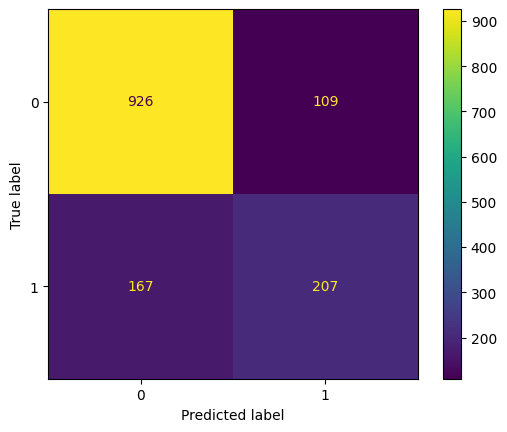

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()


In [14]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.55      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.74      1409
weighted avg       0.80      0.80      0.80      1409

ROC-AUC: 0.8424629931023793


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced'
)

rf_model.fit(X_train, y_train)

import joblib

joblib.dump(X_train.columns.tolist(), "feature_columns.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(log_model, "log_model.pkl")
joblib.dump(rf_model, "rf_model.pkl")
joblib.dump(le, "label_encoder.pkl")


rf_pred = rf_model.predict(X_test)
rf_prob = rf_model.predict_proba(X_test)[:, 1]


In [16]:
print("Logistic ROC-AUC:", roc_auc_score(y_test, y_prob))
print("Random Forest ROC-AUC:", roc_auc_score(y_test, rf_prob))


Logistic ROC-AUC: 0.8424629931023793
Random Forest ROC-AUC: 0.8245705133173165


In [17]:
import pandas as pd

feature_importance = pd.Series(
    rf_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

feature_importance.head(10)


TotalCharges                      0.177273
tenure                            0.164566
MonthlyCharges                    0.151406
Contract_Two year                 0.059623
InternetService_Fiber optic       0.040754
PaymentMethod_Electronic check    0.035761
Contract_One year                 0.029983
OnlineSecurity_Yes                0.028859
gender_Male                       0.025542
PaperlessBilling_Yes              0.023940
dtype: float64

In [20]:
y_prob = rf_model.predict_proba(X_test)[:, 1]
y_true = y_test


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

thresholds = np.arange(0.1, 0.9, 0.05)

results = []

for t in thresholds:
    y_pred = (y_prob >= t).astype(int) #threshold is 0.5 by default
    
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    results.append([t, precision, recall, f1, tp, fp, fn, tn])


In [22]:
import pandas as pd

threshold_df = pd.DataFrame(
    results,
    columns=["Threshold", "Precision", "Recall", "F1", "TP", "FP", "FN", "TN"]
)

threshold_df


,Threshold,Precision,Recall,F1,TP,FP,FN,TN
0,0.10,0.391553,0.917112,0.548800,343,533,31,502
1,0.15,0.438247,0.882353,0.585626,330,423,44,612
2,0.20,0.474006,0.828877,0.603113,310,344,64,691
3,0.25,0.498299,0.783422,0.609148,293,295,81,740
4,0.30,0.524178,0.724599,0.608305,271,246,103,789
5,0.35,0.554084,0.671123,0.607013,251,202,123,833
6,0.40,0.577608,0.606952,0.591917,227,166,147,869
7,0.45,0.604167,0.542781,0.571831,203,133,171,902
8,0.50,0.630508,0.497326,0.556054,186,109,188,926
9,0.55,0.649402,0.435829,0.521600,163,88,211,947


In [25]:
cost_fp = 100     # Cost of contacting non-churner
cost_fn = 2000    # Cost of losing a churn customer

threshold_df["Business_Cost"] = (
    threshold_df["FP"] * cost_fp +
    threshold_df["FN"] * cost_fn
)
threshold_df_sorted = threshold_df.sort_values("Business_Cost")
threshold_df_sorted



,Threshold,Precision,Recall,F1,TP,FP,FN,TN,Business_Cost
0,0.10,0.391553,0.917112,0.548800,343,533,31,502,115300
1,0.15,0.438247,0.882353,0.585626,330,423,44,612,130300
2,0.20,0.474006,0.828877,0.603113,310,344,64,691,162400
3,0.25,0.498299,0.783422,0.609148,293,295,81,740,191500
4,0.30,0.524178,0.724599,0.608305,271,246,103,789,230600
5,0.35,0.554084,0.671123,0.607013,251,202,123,833,266200
6,0.40,0.577608,0.606952,0.591917,227,166,147,869,310600
7,0.45,0.604167,0.542781,0.571831,203,133,171,902,355300
8,0.50,0.630508,0.497326,0.556054,186,109,188,926,386900
9,0.55,0.649402,0.435829,0.521600,163,88,211,947,430800


In [ ]:
best_threshold = threshold_df_sorted.iloc[0]["Threshold"]
best_threshold
joblib.dump(best_threshold, "best_threshold.pkl")



np.float64(0.1)

In [27]:
y_final_pred = (y_prob >= best_threshold).astype(int)


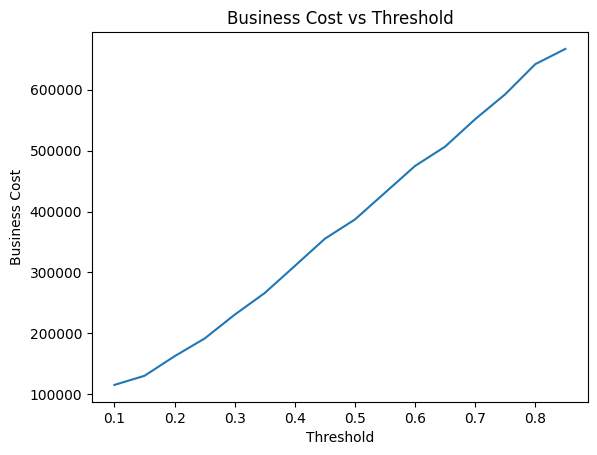

In [28]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(threshold_df["Threshold"], threshold_df["Business_Cost"])
plt.xlabel("Threshold")
plt.ylabel("Business Cost")
plt.title("Business Cost vs Threshold")
plt.show()


## 📌 Final Business Decision Summary

- The model outputs churn probabilities for each customer.
- Instead of using the default 0.5 threshold, multiple thresholds were evaluated.
- Business cost was calculated using False Positives and False Negatives.
- Missing a churn customer was assigned a significantly higher cost.
- The threshold that minimized total business cost was selected as the final decision rule.

### Final Decision Rule
Customers with churn probability greater than or equal to the selected threshold are flagged for retention action.

This approach ensures that the model aligns with real-world business priorities rather than purely statistical metrics.


In [30]:
from sklearn.metrics import confusion_matrix, classification_report

# Default threshold (0.5)
y_pred_default = rf_model.predict(X_test)

# Business-optimized threshold
y_pred_business = (y_prob >= best_threshold).astype(int)

print("🔹 Default Threshold (0.5)")
print(confusion_matrix(y_test, y_pred_default))
print(classification_report(y_test, y_pred_default))

print("\n🔹 Business Optimized Threshold")
print(confusion_matrix(y_test, y_pred_business))
print(classification_report(y_test, y_pred_business))


🔹 Default Threshold (0.5)
[[926 109]
 [188 186]]
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.63      0.50      0.56       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409


🔹 Business Optimized Threshold
[[502 533]
 [ 31 343]]
              precision    recall  f1-score   support

           0       0.94      0.49      0.64      1035
           1       0.39      0.92      0.55       374

    accuracy                           0.60      1409
   macro avg       0.67      0.70      0.59      1409
weighted avg       0.80      0.60      0.62      1409

